# Fitting forced oscillation data to suitable function


In [1]:
# Initialisation
import numpy as np
from lmfit import Model
import pandas as pd
import sympy as sym
from matplotlib import pyplot as plt
from uncertainties import ufloat

XLSX_LOC = 'E5data.xlsx'
XLSX_SHEET_NAME = 'E5-forced'

In [2]:
raw_df = pd.read_excel(XLSX_LOC, sheet_name=XLSX_SHEET_NAME)

df = pd.DataFrame(columns=['X', 'omega', 'I_braking'])

# Get 0.3A data
df1_raw = raw_df.iloc[7:22]
df1 = pd.DataFrame()
df1['X'] = df1_raw['Unnamed: 6'].astype(np.float64)
df1['omega'] = df1_raw['Unnamed: 3'].astype(np.float64)
df1['I_braking'] = 0.3
df = df.append(df1)

# Get 0.6A data
df2_raw = raw_df.iloc[26:34]
df2 = pd.DataFrame()
df2['X'] = df2_raw['Unnamed: 6'].astype(np.float64)
df2['omega'] = df2_raw['Unnamed: 3'].astype(np.float64)
df2['I_braking'] = 0.6
df = df.append(df2)

# Reindex
df = df.reset_index(drop=True).reset_index().set_index(['I_braking', 'index'])

X     omega
I_braking index                 
0.3       0       0.45  5.317223
          1       0.85  4.472018
          2       2.90  3.690564
          3       4.00  3.580163
          4       4.50  3.544815
          5       5.15  3.507982
          6      13.05  3.412456
          7      14.50  3.396316
          8      14.00  3.366744
          9      12.25  3.306940
          10      8.80  3.245926
          11      4.20  3.056449
          12      1.80  2.548960
          13      1.30  2.148832
          14      1.00  1.656085
0.6       15      0.95  1.669950
          16      1.40  2.390862
          17      3.00  3.055033
          18      3.85  3.248323
          19      3.70  3.380653
          20      3.20  3.482367
          21      1.50  3.973556
          22      0.45  5.244729

In [3]:
# Setup lmfit model
def fit_func(omega_, f_, omega0_, gamma_):
    return f_/(np.sqrt((omega0_**2-omega_**2)**2+4*(gamma_**2)*(omega_**2)))

model = Model(fit_func)

# Setup SymPy
omega, f, omega0, gamma, X = sym.symbols('omega,f,omega0,gamma,X')
eq = sym.Eq(f/(sym.sqrt((omega0**2-omega**2)**2+4*(gamma**2)*(omega**2))), X)

In [60]:
results = {}
for damp_deg in [0.3, 0.6]:
    # Set up SymPy equations

    eqs = []
    for i in [0, 2, 4]:
        eqs.append(eq.subs([(X, df.loc[damp_deg]['X'].iloc[i]), (omega, df.loc[damp_deg]['omega'].iloc[i])]))

    sol = sym.nsolve(eqs, (omega0, gamma, f), (3, 1, 10), dict=True, verify=False)
    
    params = model.make_params(omega0_=np.float64(sol[0][omega0]), f_=np.float64(sol[0][f]), gamma_=np.float64(sol[0][gamma]))
    params['omega0_'].min = 2
    params['omega0_'].max = 5
    params['f_'].min = 0
    params['gamma_'].min = 0

    result = model.fit(df.loc[damp_deg]['X'], params, omega_=df.loc[damp_deg]['omega'], method='Nelder')
    
    results[damp_deg] = result

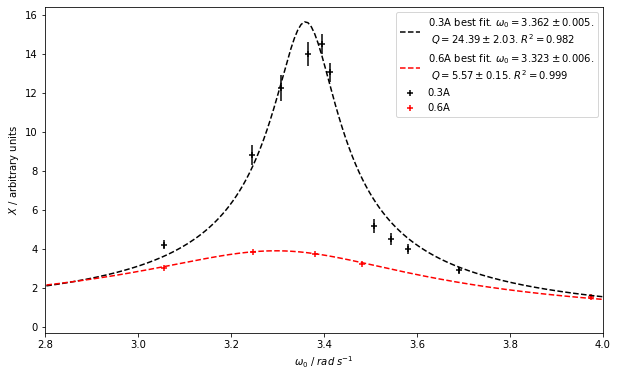

In [80]:
colors = {
    0.3: 'k',
    0.6: 'r'
}

NUM_FIT_POINTS = 500

fig, ax = plt.subplots(figsize=(10, 6))
for deg_damp, result in results.items():
    x_vals = df.loc[deg_damp]['omega']
    y_vals = df.loc[deg_damp]['X']
    x_vals_dense = np.linspace(min(x_vals), max(x_vals), NUM_FIT_POINTS)

    r_squared = 1 - result.residual.var() / np.var(y_vals)

    uomega0 = ufloat(result.params['omega0_'].value, result.params['omega0_'].stderr)
    ugamma = ufloat(result.params['gamma_'].value, result.params['gamma_'].stderr)
    q_factor = uomega0/(2*ugamma)

    plt.scatter(x_vals, y_vals, None, colors[deg_damp], '+')
    plt.errorbar(x_vals, y_vals, xerr=None, yerr=list(result.eval_uncertainty()), ecolor=colors[deg_damp], fmt='none')
    plt.plot(x_vals_dense, result.model.eval(result.params, omega_=x_vals_dense), colors[deg_damp] + '--', label=f'{deg_damp}A best fit. $\omega_0={result.params["omega0_"].value:.3f}\pm{result.params["omega0_"].stderr:0.3f}$.\n $Q={q_factor.n:.2f}\pm{q_factor.s:.2f}$. $R^2={r_squared:.3f}$')


ax.set_xlim(2.8, 4.0)
ax.set_ylabel('$X$ / arbitrary units')
ax.set_xlabel('$\omega_0$ / $rad\; s^{-1}$')
plt.legend()